In [1]:
# So we can use the *thesislib* package
import sys
import os

module_path = os.path.abspath("..")

if module_path not in sys.path:
    sys.path.append(module_path)

In [23]:
from thesislib.utils import pathutils
from thesislib.utils.ml import models

In [3]:
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [4]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
train_dump = pathutils.get_data_file('prob-synthea-1/output/train.json')
test_dump = pathutils.get_data_file('prob-synthea-1/output/test.json')

In [14]:
train_df = pd.read_json(train_dump)
_df = train_df.drop(columns=["labels"])
_targets = train_df['labels']

In [7]:
cross_val_split = StratifiedKFold(n_splits=5)

In [16]:
_df.shape

(316650, 49)

In [20]:
# We'll start with the RandomForest classifier, which we'd used previously
rf_clf = RandomForestClassifier(n_estimators=140, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=2, random_state=None, verbose=0, warm_start=False, class_weight=None)

In [8]:
num_procs = os.cpu_count()

In [34]:
rf_trn_sizes, rf_trn_scores, rf_test_scores = learning_curve(
    estimator=rf_clf,
    X=_df,
    y=_targets,
    train_sizes=np.linspace(0.1, 1, 5),
    cv=cross_val_split,
    n_jobs=num_procs
)

In [28]:
# plot this graph!
def plot_learning_curve(axes, title, train_sizes, train_scores, test_scores, ylim=None):
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    axes.set_title(title)
    
    if ylim is not None:
        axes.set_ylim(*ylim)
    
    axes.grid()
    axes.fill_between(
        train_sizes, train_scores_mean - train_scores_std, 
        train_scores_mean + train_scores_std, alpha=0.1, color="r"
    )
    axes.fill_between(
        train_sizes, test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std, alpha=0.1, color="g"
    )
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Train Accuracy")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation Accuracy")
    axes.legend(loc="best")
    return axes

def auc_scorer(estimator, X, y):
    y_pred = estimator.predict_proba(X)
    
    return roc_auc_score(y_true=y, y_score=y_pred, average='weighted', multi_class='ovr')

In [34]:
train_ylim=(0.85, 0.99)
auc_ylimc = (0.98, 1.01)

NameError: name 'rf_trn_sizes' is not defined

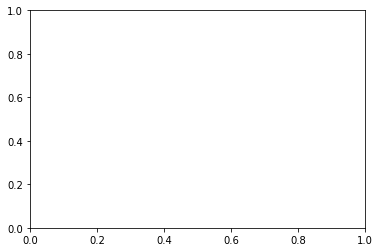

In [38]:
rf_fig, rf_axes = plt.subplots()
rf_title = "Learning Curve for Random Forest Classifier"

plot_learning_curve(rf_axes, rf_title, rf_trn_sizes, rf_trn_scores, rf_test_scores)

#rf_fig.set_size_inches(5, 5)
rf_fig.savefig(pathutils.get_data_file("compare-models/output/rf_learning_curve.pdf"), bbox_inches='tight')

In [25]:
# now we do the same thing as well for the NaiveBayes Classifier
from sklearn import naive_bayes

num_classes = len(_targets.unique().tolist())
equal_class_prior = [1.0/num_classes for idx in range(num_classes)]

symptom_gender_clf = naive_bayes.BernoulliNB(fit_prior=False)
race_clf = naive_bayes.MultinomialNB(fit_prior=False)
age_clf = naive_bayes.GaussianNB(priors=equal_class_prior)

symptoms = [itm for itm in _df.columns if len(itm) == 56]

symtom_gender = ["gender"] + symptoms

classifier_map = [[symptom_gender_clf, symtom_gender], [race_clf, ["race"]], [age_clf, ["age"]]]
tnb = models.ThesisNaiveBayes(classifier_map)

In [35]:
nb_trn_sizes, nb_trn_scores, nb_test_scores = learning_curve(
    estimator=tnb,
    X=_df,
    y=_targets,
    train_sizes=np.linspace(0.01, 1, 5),
    cv=cross_val_split,
    n_jobs=num_procs,
)

/Users/teliov/Library/anaconda3/envs/ml/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


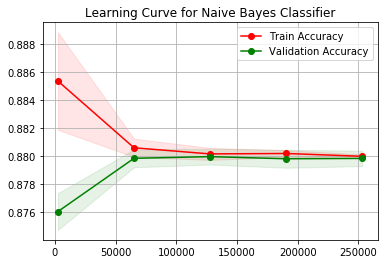

In [37]:
nb_fig, nb_axes = plt.subplots()
nb_title = "Learning Curve for Naive Bayes Classifier"
plot_learning_curve(nb_axes, nb_title, nb_trn_sizes, nb_trn_scores, nb_test_scores)

# nb_fig.set_size_inches(10, 10)
nb_fig.savefig(pathutils.get_data_file("compare-models/output/naive_bayes_learning_curve.pdf"), bbox_inches='tight')

In [17]:
# So we've gotten the Learning Curve, how about the AUC.
# Also what other metrics can we use
# Let's try the AUC score
nb_trn_sizes, nb_trn_scores, nb_test_scores = learning_curve(
    estimator=tnb,
    X=_df,
    y=_targets,
    train_sizes=np.linspace(0.01, 1, 5),
    cv=cross_val_split,
    n_jobs=num_procs,
    scoring=auc_scorer
)

/Users/teliov/Library/anaconda3/envs/ml/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
# AUC also for the RandomForest ..


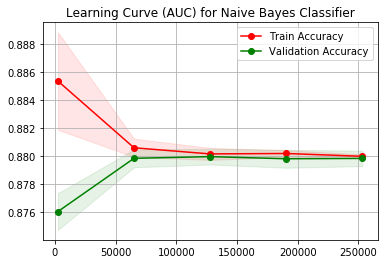

In [39]:
nb_fig_auc, nb_axes_auc = plt.subplots()
nb_title_auc = "Learning Curve (AUC) for Naive Bayes Classifier"
plot_learning_curve(nb_axes_auc, nb_title_auc, nb_trn_sizes, nb_trn_scores, nb_test_scores)

# nb_fig_auc.set_size_inches(10, 10)
nb_fig_auc.savefig(pathutils.get_data_file("compare-models/output/naive_bayes_learning_auc_curve.pdf"), bbox_inches='tight')

In [39]:
rf_auc_trn_sizes, rf_auc_trn_scores, rf_auc_test_scores = learning_curve(
    estimator=rf_clf,
    X=_df,
    y=_targets,
    train_sizes=np.linspace(0.1, 1, 5),
    cv=cross_val_split,
    n_jobs=num_procs,
    scoring=auc_scorer
)

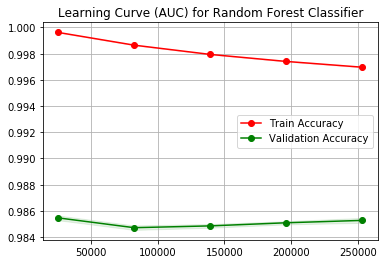

In [41]:
rf_auc_fig, rf_auc_axes = plt.subplots()
rf_auc_title = "Learning Curve (AUC) for Random Forest Classifier"

plot_learning_curve(rf_auc_axes, rf_auc_title, rf_auc_trn_sizes, rf_auc_trn_scores, rf_auc_test_scores)

# rf_auc_fig.set_size_inches(10, 10)
rf_auc_fig.savefig(pathutils.get_data_file("compare-models/output/rf_auc_learning_curve.pdf"), bbox_inches='tight')